# Thunderstruck
## Global diagnostics

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from dataclasses import dataclass, field
from functools import partial

import iris
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
import paths
from aeolus.calc import precip_sum, spatial
from aeolus.const import init_const
from aeolus.core import AtmoSim
from aeolus.model import um
from aeolus.plot import (
    add_custom_legend,
    figsave,
    subplot_label_generator,
    tex2cf_units,
    unit_format,
)
from matplotlib.offsetbox import AnchoredText
from tqdm.notebook import tqdm

In [3]:
from common import (
    ACCUM_PERIOD,
    GROUPS,
    KW_DELIM_LINE,
    KW_TEXT,
    LPC,
    M09,
    PR92,
    PROJECT,
    SIMULATIONS,
    calc_cloud_depth,
    calc_flash_rate,
    calc_total_flash_rate,
    callback_coord_system,
    extract_lfr_ratio,
)

In [4]:
SIM_GROUP = "pres"
show_groups = [SIM_GROUP]  # "comp", "surf"
show_sim = [
    sim
    for sim in SIMULATIONS.keys()
    if sim in sum([GROUPS[SIM_GROUP].simulations for SIM_GROUP in show_groups], ())
]
n_sim = len(show_sim)

In [5]:
dset = {}
for sim in tqdm(show_sim):
    dset[sim] = {}
    const = init_const("trap1e")  # TODO
    for scheme in LPC:
        dset[sim][scheme] = AtmoSim(
            iris.load(
                paths.data
                / "raw"
                / "steady"
                / SIMULATIONS[sim].diag_suites[LPC[scheme].suites]
                / "base"
                / LPC[scheme].model_res
                / LPC[scheme].file_mask,
                callback=partial(callback_coord_system, const=const),
            ),
            planet="trap1e",  # TODO
            model=um,
        )

  0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
for scheme in LPC:
    for i, cube in enumerate(dset[sim][scheme]._cubes):
        print(f"--|-|-{'-'*20}-|-{'-'*10}-|-{'-'*65}-|-{'-'*10}")
        print(
            f"{i:<2d}|{cube.ndim}| {str(cube.shape):>20}"
            f" | {str(cube.attributes['STASH']):>10}"
            f" | {cube.name():>65} | {str(cube.units):>10}"
        )
    print("-" * 120)

--|-|----------------------|------------|-------------------------------------------------------------------|-----------
0 |3|     (10, 1920, 2560) | m01s09i217 |               cloud_area_fraction_assuming_maximum_random_overlap |          1
--|-|----------------------|------------|-------------------------------------------------------------------|-----------
1 |3|     (10, 1920, 2560) | m01s21i102 |                                                graupel_water_path |     kg m-2
--|-|----------------------|------------|-------------------------------------------------------------------|-----------
2 |3|     (10, 1920, 2560) | m01s21i103 |                                              total_ice_water_path |     kg m-2
--|-|----------------------|------------|-------------------------------------------------------------------|-----------
3 |3|     (10, 1920, 2560) | m01s21i104 |                                       Number_of_lightning_flashes |          1
--|-|----------------------|----

In [7]:
@dataclass
class Diag:
    recipe: callable
    title: str
    units: str
    lim: tuple = ()
    scale: str = "linear"
    unit_format_kwargs: dict = field(default_factory=lambda: {})
    rangebar: bool = False
    bins: list = field(default_factory=list)
    scheme: str = "m09"

### LFR and cloud depths in the PR92 simulations

In [8]:
DIAGS = {
    "cld_dep": Diag(
        recipe=calc_cloud_depth,
        title="Convective Cloud Depth",
        units="$km$",
        bins=np.arange(0, 21, 1),
        scheme="pr92",
    ),
    "num_fl_pr92": Diag(
        recipe=partial(calc_total_flash_rate, accum_period=ACCUM_PERIOD),
        title=f"Flash Rate",
        units="$s^{-1}$",
        lim=[5e-3, 5],
        scale="log",
        scheme="pr92",
    ),
}

Saved to ../figures/thunderstruck__pres__cld_dep_num_fl_pr92__global.pdf
Size: 37.3 KB


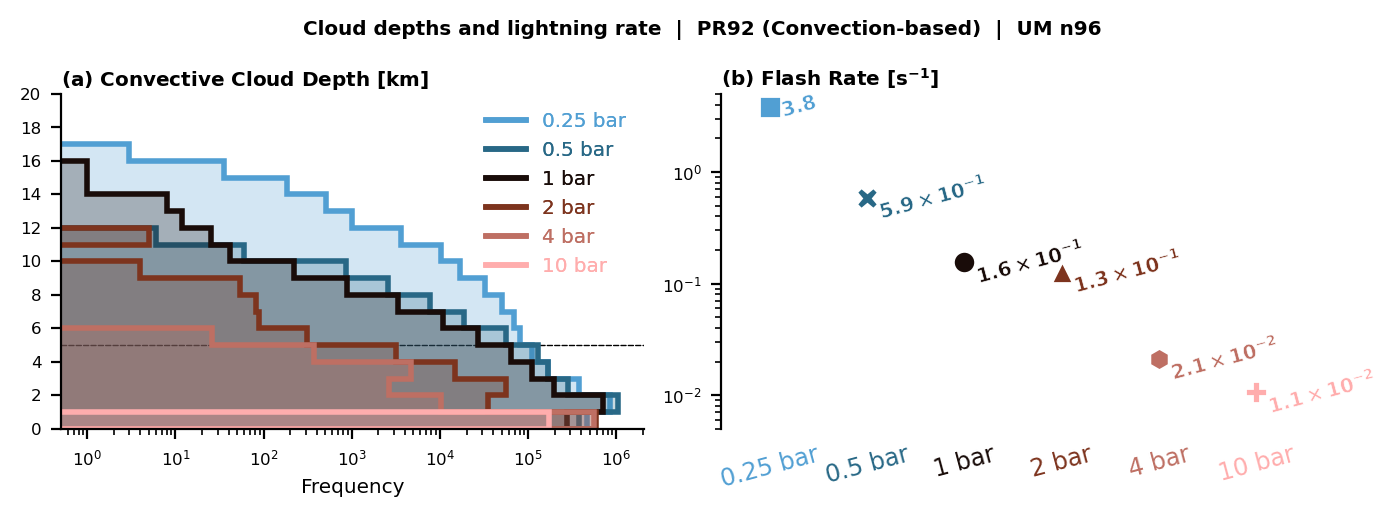

In [12]:
scheme = "pr92"
diag_keys = ["cld_dep", "num_fl_pr92"]
sep = "  |  "
savefig = True

ttl = sep.join(
    [
        "Cloud depths and lightning rate",
        LPC[scheme].title,
        f"UM {LPC[scheme].model_res}",
    ]
)

fig = plt.figure(figsize=(7, 2.5), layout="constrained")
fig.suptitle(ttl)
axd = fig.subplot_mosaic([diag_keys])

iletters = subplot_label_generator()

# Cloud depth
diag_key = "cld_dep"
ax = axd[diag_key]
ax.set_title(
    f"({next(iletters)}) {DIAGS[diag_key].title} [{DIAGS[diag_key].units}]", loc="left"
)
ax.set_ylim(DIAGS[diag_key].bins[0], DIAGS[diag_key].bins[-1])
ax.set_yticks(DIAGS[diag_key].bins[::2])
ax.set_xscale("log")
ax.set_xlabel("Frequency", fontsize="large", labelpad=-5)
if diag_key == "cld_dep":
    ax.axhline(5, lw=0.5, **KW_DELIM_LINE)
add_custom_legend(
    ax,
    {
        SIMULATIONS[sim].title: {
            "color": SIMULATIONS[sim].kw_plt["color"],
            "lw": 2,
        }
        for sim in GROUPS[SIM_GROUP].simulations
    },
    loc="upper right",
    frameon=False,
    fontsize="large",
)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# ax.spines.bottom.set_visible(False)
# ax.set_ylim(DIAGS[diag_key].lim)
# ax.spines.left.set_bounds(DIAGS[diag_key].lim)
# ax.tick_params(axis="x", which="both", length=0, pad=5)
# ax.grid(visible=False, axis="x")

stacked_data = []
for sim in GROUPS[SIM_GROUP].simulations:
    cube = DIAGS[diag_key].recipe(dset[sim][DIAGS[diag_key].scheme]._cubes)
    cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
    cube_data = cube.data.ravel().compressed()
    #     stacked_data.append(cube.data.ravel())
    # stacked_data = np.stack(stacked_data, axis=1)

    ax.hist(
        cube_data,
        DIAGS[diag_key].bins,
        histtype="step",
        fill=True,
        alpha=0.25,
        orientation="horizontal",
        edgecolor="none",
        color=SIMULATIONS[sim].kw_plt["color"],
    )
    ax.hist(
        cube_data,
        DIAGS[diag_key].bins,
        histtype="step",
        fill=False,
        orientation="horizontal",
        linewidth=2,
        color=SIMULATIONS[sim].kw_plt["color"],
    )

# LFR
diag_key = "num_fl_pr92"
txt_hor_offset = 0.1
ax = axd[diag_key]
ax.set_title(
    f"({next(iletters)}) {DIAGS[diag_key].title} [{DIAGS[diag_key].units}]", loc="left"
)
for isim, sim in enumerate(GROUPS[SIM_GROUP].simulations):
    cube = DIAGS[diag_key].recipe(dset[sim][DIAGS[diag_key].scheme]._cubes)
    cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
    value_mean = float(LPC[scheme].time_ave_func(spatial(cube, "mean")).data)
    ax.plot(
        isim,
        value_mean,
        marker=SIMULATIONS[sim].kw_plt["marker"],
        markersize=8,
        markeredgecolor="w",
        color=SIMULATIONS[sim].kw_plt["color"],
    )
    KW_TEXT.update(color=SIMULATIONS[sim].kw_plt["color"])
    try:
        ax.text(
            isim + txt_hor_offset,
            value_mean,
            unit_format(value_mean, **DIAGS[diag_key].unit_format_kwargs),
            va="center",
            **KW_TEXT,
        )
    except Exception as e:
        print(e)
ax.set_xlim(-0.5, len(GROUPS[SIM_GROUP].simulations) - 0.5)
ax.set_xticks(range(len(GROUPS[SIM_GROUP].simulations)))
ax.set_xticklabels(
    [SIMULATIONS[sim].title for sim in GROUPS[SIM_GROUP].simulations],
    size="x-large",
    rotation=15,
)
for xtick, sim in zip(ax.get_xticklabels(), GROUPS[SIM_GROUP].simulations):
    xtick.set_color(SIMULATIONS[sim].kw_plt["color"])
ax.set_yscale(DIAGS[diag_key].scale)
ylabel = f"{DIAGS[diag_key].title}"
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.set_ylim(DIAGS[diag_key].lim)
ax.spines.left.set_bounds(DIAGS[diag_key].lim)
ax.tick_params(axis="x", which="both", length=0, pad=5)
ax.grid(visible=False, axis="x")

fig.tight_layout()
fig.align_labels()

if savefig:
    figsave(
        fig,
        paths.figures / f"{PROJECT}__{SIM_GROUP}__{'_'.join(diag_keys)}__global",
    )

### Mean / min / max values in the M09 simulations

In [ ]:
DIAGS = {
    "t_sfc": Diag(
        recipe=lambda cl: cl.extract_cube(um.t_sfc),
        title="Surface Temperature",
        units="K",
        lim=[140, 320],
        scale="linear",
        unit_format_kwargs=dict(exponent=1),
        rangebar=True,
    ),
    "caf": Diag(
        recipe=lambda cl: cl.extract_cube(um.caf),
        title="Cloud Fraction",
        units="%",
        lim=[0, 100],
        unit_format_kwargs=dict(exponent=1),
    ),
    "ls_prec": Diag(
        recipe=partial(precip_sum, const=const),
        title="Large-scale Precipitation Rate",
        units="$mm$ $day^{-1}$",
        lim=[0, 1.5],
    ),
    "num_fl_m09": Diag(
        recipe=partial(calc_total_flash_rate, accum_period=ACCUM_PERIOD),
        title=f"Flash Rate | {M09.short_title}",
        units="$s^{-1}$",
        lim=[0, 10],
        # lim=[5e-3, 5],
        # scale="log",
    ),
    "num_fl_pr92": Diag(
        recipe=partial(calc_total_flash_rate, accum_period=ACCUM_PERIOD),
        title=f"Flash Rate | {PR92.short_title}",
        units="$s^{-1}$",
        lim=[5e-3, 5],
        scale="log",
        scheme="pr92",
    ),
    "iwp": Diag(
        recipe=lambda cl: cl.extract_cube("total_ice_water_path"),
        title="Total Ice Water Path",
        units="$g$ $m^{-2}$",
        lim=[10, 100],
    ),
    "gwp": Diag(
        recipe=lambda cl: cl.extract_cube("graupel_water_path"),
        title="Graupel Water Path",
        units="$g$ $m^{-2}$",
        lim=[1e-6, 1e-1],
        scale="log",
    ),
}

In [ ]:
diag_computed = {}
for sim in tqdm(show_sim):
    diag_computed[sim] = {}
    for diag_key in tqdm(DIAGS.keys(), leave=False):
        cube = DIAGS[diag_key].recipe(dset[sim][DIAGS[diag_key].scheme]._cubes)
        cube.convert_units(tex2cf_units(DIAGS[diag_key].units))
        diag_computed[sim][diag_key] = {
            "mean": float(
                LPC[DIAGS[diag_key].scheme].time_ave_func(spatial(cube, "mean")).data
            ),
        }
        if DIAGS[diag_key].rangebar:
            diag_computed[sim][diag_key].update(
                {
                    "min": float(
                        LPC[DIAGS[diag_key].scheme]
                        .time_ave_func(spatial(cube, "min"))
                        .data
                    ),
                    "max": float(
                        LPC[DIAGS[diag_key].scheme]
                        .time_ave_func(spatial(cube, "max"))
                        .data
                    ),
                }
            )

In [ ]:
diag_keys = ["t_sfc", "caf", "ls_prec", "gwp", "iwp", "num_fl_m09"]
txt_hor_offset = 0.1
savefig = True

fig = plt.figure(figsize=(7, 5), layout="constrained")
fig.suptitle("Global Climate Diagnostics", fontweight="bold")
axd = fig.subplot_mosaic(np.array_split(diag_keys, len(diag_keys) // 2), sharex=True)

iletters = subplot_label_generator()
for diag_key in diag_keys:
    ax = axd[diag_key]
    for isim, sim in enumerate(GROUPS[SIM_GROUP].simulations):
        value_mean = diag_computed[sim][diag_key]["mean"]
        if DIAGS[diag_key].rangebar:
            value_min = diag_computed[sim][diag_key]["min"]
            value_max = diag_computed[sim][diag_key]["max"]
            yerr = [[abs(value_min - value_mean)], [abs(value_max - value_mean)]]
            ax.errorbar(
                isim,
                value_mean,
                yerr=yerr,
                fmt=SIMULATIONS[sim].kw_plt["marker"],
                capsize=5,
                capthick=2,
                markersize=8,
                markeredgecolor="w",
                color=SIMULATIONS[sim].kw_plt["color"],
                clip_on=False,
                elinewidth=2,
            )
        else:
            ax.plot(
                isim,
                value_mean,
                marker=SIMULATIONS[sim].kw_plt["marker"],
                markersize=8,
                markeredgecolor="w",
                color=SIMULATIONS[sim].kw_plt["color"],
                clip_on=False,
            )
        KW_TEXT.update(color=SIMULATIONS[sim].kw_plt["color"])
        try:
            ax.text(
                isim + txt_hor_offset,
                value_mean,
                unit_format(value_mean, **DIAGS[diag_key].unit_format_kwargs),
                va="center",
                **KW_TEXT,
            )
            if DIAGS[diag_key].rangebar:
                ax.text(
                    isim + txt_hor_offset,
                    value_max,
                    unit_format(value_max, **DIAGS[diag_key].unit_format_kwargs),
                    va="center",
                    **KW_TEXT,
                )
                ax.text(
                    isim + txt_hor_offset,
                    value_min,
                    unit_format(value_min, **DIAGS[diag_key].unit_format_kwargs),
                    va="center",
                    **KW_TEXT,
                )
        except Exception as e:
            print(e)
            pass
    ax.set_xlim(-0.5, len(GROUPS[SIM_GROUP].simulations) - 0.5)
    ax.set_xticks(range(len(GROUPS[SIM_GROUP].simulations)))
    ax.set_xticklabels(
        [SIMULATIONS[sim].title for sim in GROUPS[SIM_GROUP].simulations],
        size="x-large",
        rotation=15,
    )
    for xtick, sim in zip(ax.get_xticklabels(), GROUPS[SIM_GROUP].simulations):
        xtick.set_color(SIMULATIONS[sim].kw_plt["color"])
    ax.set_yscale(DIAGS[diag_key].scale)
    ylabel = f"{DIAGS[diag_key].title}"
    if (tex_units := DIAGS[diag_key].units) != "1":
        ylabel += f" [{tex_units}]"
    ylabel = ylabel.replace("\n", " ")
    ax.set_title(f"({next(iletters)}) {ylabel}", loc="left")

    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.set_ylim(DIAGS[diag_key].lim)
    ax.spines.left.set_bounds(DIAGS[diag_key].lim)
    ax.tick_params(axis="x", which="both", length=0, pad=5)
    ax.grid(visible=False, axis="x")

if savefig:
    figsave(
        fig,
        paths.figures / f"{PROJECT}__{SIM_GROUP}__{'_'.join(diag_keys)}__global",
    )